# Data Preprocessing / Feature Creation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Clean data
clean_df=pd.read_pickle("WM811K_clean.pkl")

# Define function for repeatability of plotting
def plot_wafer_maps(df, number_of_subplots):
    """
    Plots first number_of_subplots of wafer map images from df dataframe using Wafer_Map and Defect_Class columns.
    Creates grid of subplots. Please only input number_of_subplots in units of 10.
    """
    dfreset = df.reset_index()
    nrows = int(number_of_subplots / 10)
    fig, ax = plt.subplots(nrows = nrows, ncols = 10, figsize=(20, nrows * 2))
    ax = ax.ravel(order='C')         # This is necessary to loop all subplots with 1 index
    for i in range(number_of_subplots):
        img = dfreset.Wafer_Map[i]
        ax[i].imshow(img)
        title = f'{dfreset.index[i]} - {dfreset.Defect_Class[i]}'
        ax[i].set_title(title)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show() 

### Removing Isolated Defects

 To simplify classification, we will drop all defects that have no neighboring defects which does not affect our defect patterns for classification and might even improve interpretation of model.

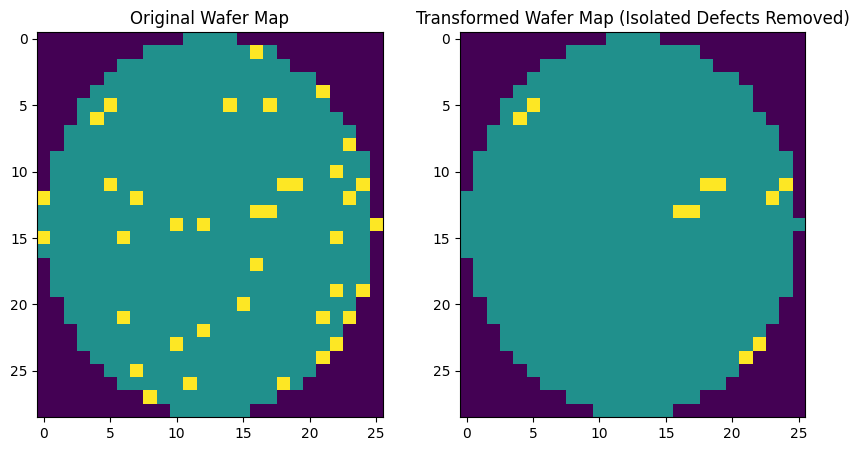

In [2]:
from scipy.ndimage import generic_filter
from joblib import Parallel, delayed

def remove_isolated_defects(wafer_map):
    """
    Converts isolated defect pixels to non-defect if all 8 neighboring pixels are either 1 or 0.
    """
    def filter_function(values):
        center = values[4]
        neighbors = np.delete(values, 4)
        if center == 2 and np.all(np.isin(neighbors, [0, 1])):
            return 1
        return center

    # Apply the filter with a 3x3 moving window
    return generic_filter(wafer_map, filter_function, size=(3, 3), mode='constant', cval=1)

# Select a random wafer map for visualization
sample_idx = np.random.choice(clean_df.index)
original_wafer_map = clean_df.loc[sample_idx, 'Wafer_Map']

# Apply transformation for visualization
transformed_wafer_map = remove_isolated_defects(original_wafer_map)

# Apply transformation to all wafer maps
clean_df['Wafer_Map'] = Parallel(n_jobs=-1)(
    delayed(remove_isolated_defects)(wm) for wm in clean_df['Wafer_Map']
)

# Plot original and transformed wafer maps
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_wafer_map, cmap='viridis')
axes[0].set_title("Original Wafer Map")
axes[1].imshow(transformed_wafer_map, cmap='viridis')
axes[1].set_title("Transformed Wafer Map (Isolated Defects Removed)")
plt.show()

### Addressing Wafer_Map Dimensions

Not all wafer maps are the same dimensions which needs to be addresed before feature creation

In [3]:
def average_wafer_dimension(clean_df):
    """
    Computes the average wafer map dimension
    """
    avg_area = clean_df['Wafer_Map'].apply(lambda x: np.prod(x.shape)).mean()
    avg_dimension = int(np.round(np.sqrt(avg_area)))
    return avg_dimension

# Compute
avg_wafer_dim = average_wafer_dimension(clean_df)
print(f"Average Wafer Map Dimension: {avg_wafer_dim} x {avg_wafer_dim}")

Average Wafer Map Dimension: 37 x 37


We will use 45 x 45 to mimize distortion of maps, while maintaining enough detail, while making wafer maps easy to handle for classification. Nearest-neighbor interpolation was performed

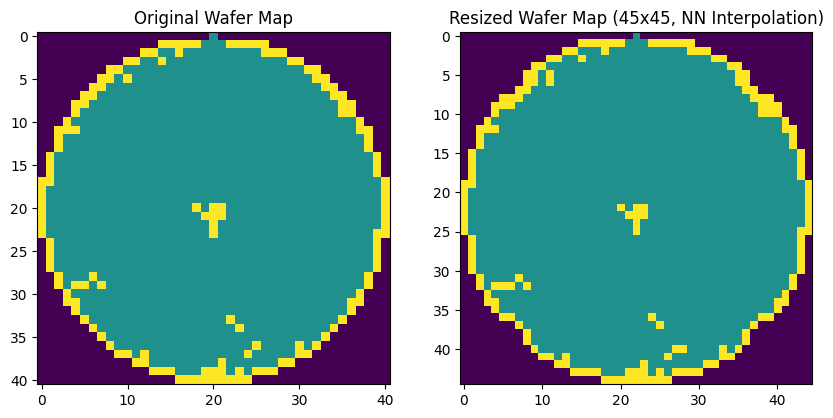

In [30]:
import scipy.ndimage

# Define resizing function with nearest-neighbor interpolation
def resize_wafer_nn(wafer_map, target_size=(45, 45)):
    zoom_factors = (target_size[0] / wafer_map.shape[0], target_size[1] / wafer_map.shape[1])
    return scipy.ndimage.zoom(wafer_map, zoom_factors, order=0)

# Select one map for visualization
sample_idx = np.random.choice(clean_df.index)
original_wafer_map = clean_df.loc[sample_idx, 'Wafer_Map']

# Resize
resized_wafer_map = resize_wafer_nn(original_wafer_map, target_size=(45, 45))

# Apply resizing to all
clean_df['Wafer_Map'] = clean_df['Wafer_Map'].apply(lambda x: resize_wafer_nn(x, target_size=(45, 45)))

# Plot sample wafer map
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_wafer_map, cmap='viridis')
axes[0].set_title("Original Wafer Map")
axes[1].imshow(resized_wafer_map, cmap='viridis')
axes[1].set_title("Resized Wafer Map (45x45, NN Interpolation)")
plt.show()

In [ ]:
avg_wafer_dim = average_wafer_dimension(clean_df)
print(f"Average Wafer Map Dimension: {avg_wafer_dim} x {avg_wafer_dim}")

Average Wafer Map Dimension: 45 x 45


Based on visual inspections, our interpolation produced good results.

### Class Imbalance

We will slightly balance data through random sampling (to reduce samples) and rotations (to increase samples). But first let's split out our validation set for later

Defect_Class
none         110569
Edge-Ring      7260
Edge-Loc       3892
Center         3220
Loc            2695
Scratch         895
Random          649
Donut           416
Near-full       112
Name: count, dtype: int64


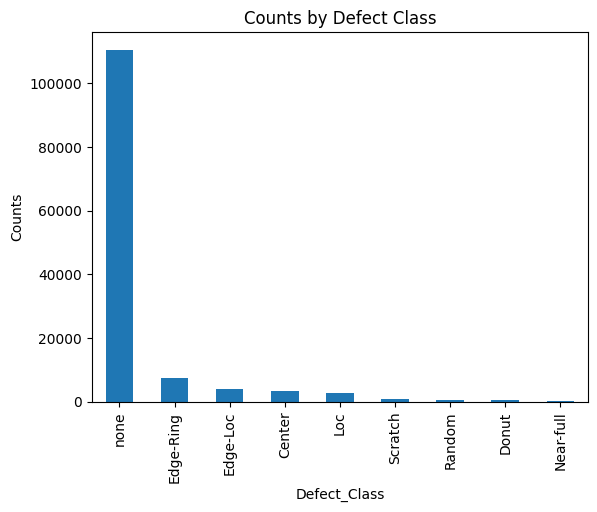

In [32]:
from sklearn.model_selection import train_test_split
import pickle

# Split data into training and validation sets
train_idx, val_idx = train_test_split(
    np.arange(len(clean_df)), test_size=0.25, random_state=5, stratify=clean_df['Defect_Class']
)

# Create validation set
val_df = clean_df.iloc[val_idx]

# Keep only training data in clean_df
clean_df = clean_df.iloc[train_idx]

# Value counts of Defect_Class
clean_df.Defect_Class.value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Counts by Defect Class')
print(clean_df.Defect_Class.value_counts())

In [33]:
# Separate "none" class from defect classes
none_df = clean_df[clean_df['Defect_Class'] == 'none']
edgering_df = clean_df[clean_df['Defect_Class'] == 'Edge-Ring']
loc_df = clean_df[clean_df['Defect_Class'] == 'Loc']
scratch_df = clean_df[clean_df['Defect_Class'] == 'Scratch']
nearfull_df = clean_df[clean_df['Defect_Class'] == 'Near-full']
donut_df = clean_df[clean_df['Defect_Class'] == 'Donut']
random_df = clean_df[clean_df['Defect_Class'] == 'Random']
edgeloc_df = clean_df[clean_df['Defect_Class'] == 'Edge-Loc']
center_df = clean_df[clean_df['Defect_Class'] == 'Center']

# Randomly sample a portion
none_sampled = none_df.sample(frac=0.09, random_state=3)
edgering_sampled = edgering_df.sample(frac=0.826, random_state=3)

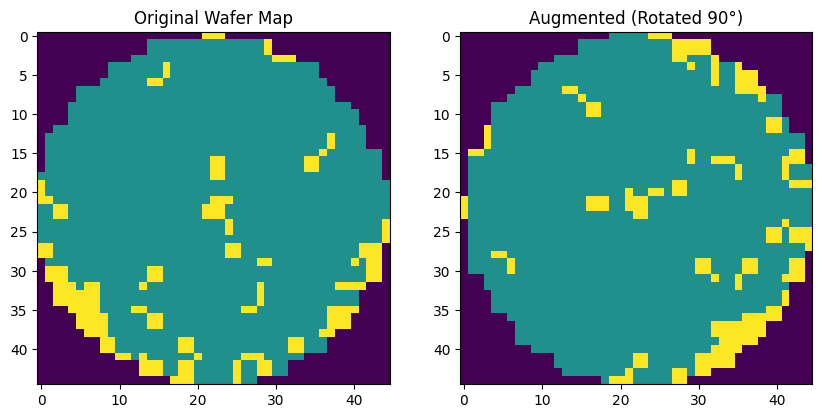

Augmented Edge-Loc from 3892 to 6000 samples.


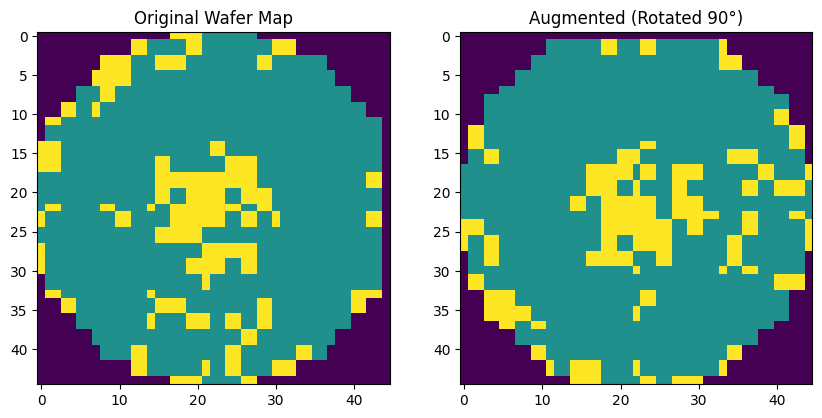

Augmented Center from 3220 to 6000 samples.


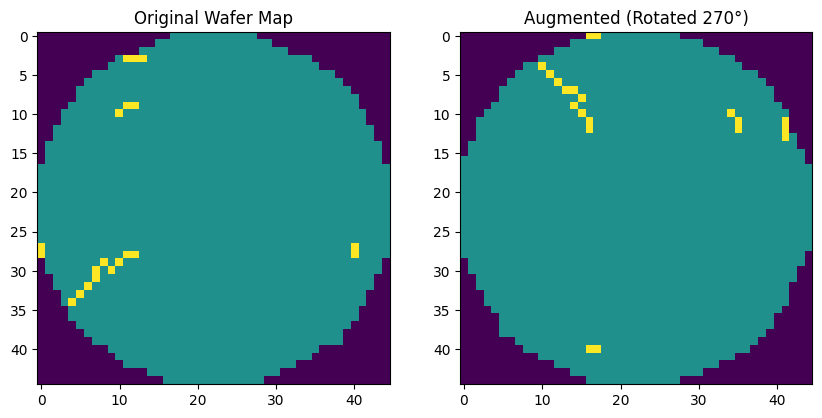

Augmented Scratch from 895 to 4000 samples.


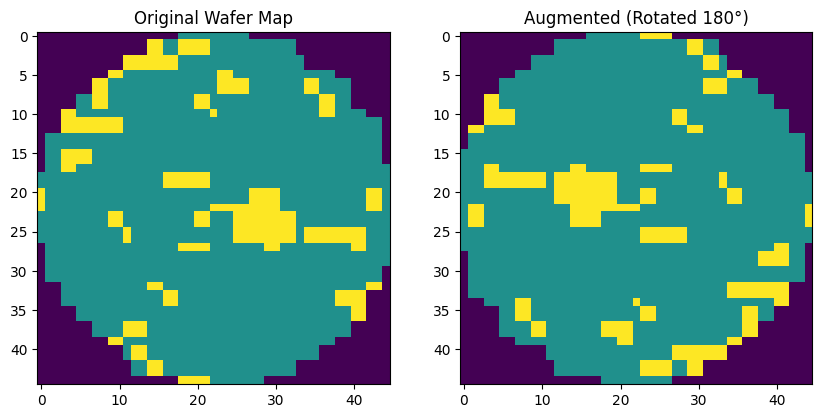

Augmented Loc from 2695 to 6000 samples.


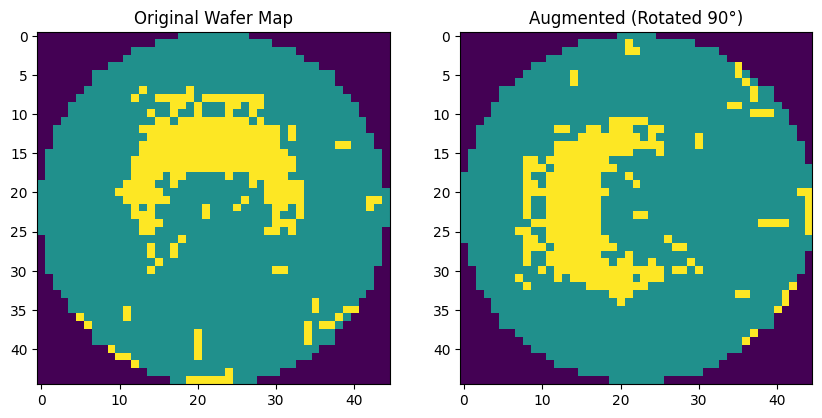

Augmented Donut from 416 to 3000 samples.


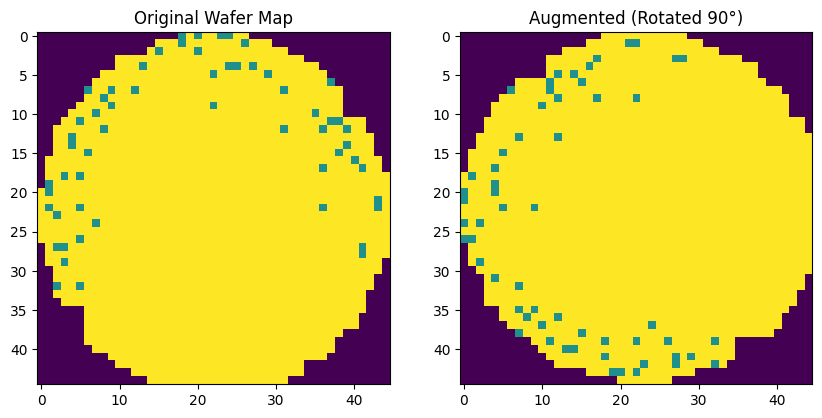

Augmented Near-full from 112 to 2000 samples.


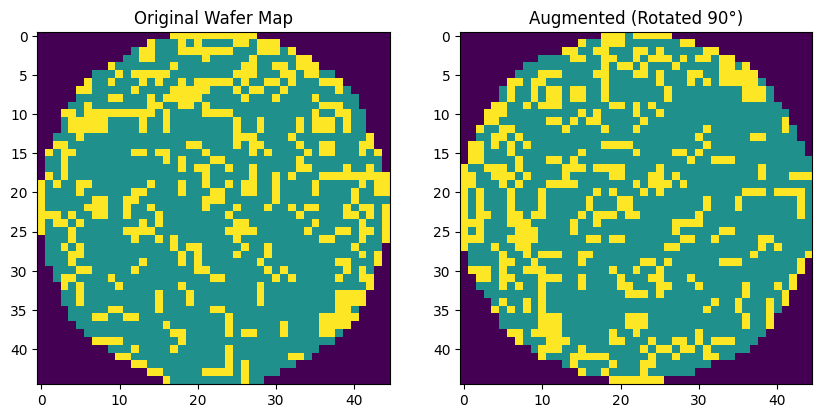

Augmented Random from 649 to 3000 samples.


In [34]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

def rotate_wafer(wafer_map, angle):
    """
    Rotates a wafer defect map by a specified angle (90, 180, 270 degrees).
    """
    k = angle // 90
    return np.rot90(wafer_map, k)

def augment_defect_class(df_class, target_count):
    """
    Augments a defect class dataset to reach the target count using random 90, 180, 270 degree rotations.
    """
    current_count = len(df_class)
    if current_count >= target_count:
        return df_class

    augment_needed = target_count - current_count
    augmented_data = []

    # Select random sample
    sampled_indices = np.random.choice(df_class.index, size=augment_needed, replace=True)

    # Pick one sample for visualization
    sample_idx = random.choice(sampled_indices)
    original_sample = df_class.loc[sample_idx, 'Wafer_Map']
    visualized_angle = None
    augmented_sample = None

    for idx in sampled_indices:
        wafer_map = df_class.loc[idx, 'Wafer_Map']
        label = df_class.loc[idx, 'Defect_Class']
        
        # Randomly select rotation
        angle = random.choice([90, 180, 270])
        rotated_map = rotate_wafer(wafer_map, angle)
        
        # Store augmented result
        augmented_data.append({'Wafer_Map': rotated_map, 'Defect_Class': label})
        if idx == sample_idx:
            augmented_sample = rotated_map
            visualized_angle = angle

    augmented_df = pd.DataFrame(augmented_data)
    final_df = pd.concat([df_class, augmented_df], ignore_index=True)

    # Plot before and after augmentation
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_sample, cmap='viridis')
    axes[0].set_title("Original Wafer Map")
    axes[1].imshow(augmented_sample, cmap='viridis')
    axes[1].set_title(f"Augmented (Rotated {visualized_angle}°)")
    plt.show()

    print(f"Augmented {df_class['Defect_Class'].iloc[0]} from {current_count} to {len(final_df)} samples.")
    return final_df

# Perform augmentation
edgeloc_df = augment_defect_class(edgeloc_df, 6000)
center_df = augment_defect_class(center_df, 6000)
scratch_df = augment_defect_class(scratch_df, 4000)
loc_df = augment_defect_class(loc_df, 6000)
donut_df = augment_defect_class(donut_df, 3000)
nearfull_df = augment_defect_class(nearfull_df, 2000)
random_df = augment_defect_class(random_df, 3000)

Text(0.5, 1.0, 'Counts by Defect Class (with Augmentation + Reduction)')

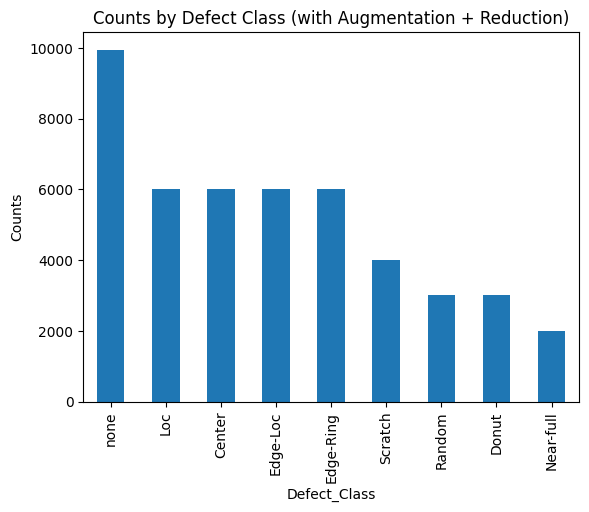

In [35]:
# Create balanced_df
balanced_df = pd.concat([none_sampled, edgering_sampled, loc_df, scratch_df, nearfull_df, donut_df, random_df, edgeloc_df, center_df], ignore_index=True)
clean_df = balanced_df

# Value counts of Defect_Class
clean_df.Defect_Class.value_counts().plot(kind='bar')
# Label y axis as counts and add Title 'Counts by Defect Class'
plt.ylabel('Counts')
plt.title('Counts by Defect Class (with Augmentation + Reduction)')

### Feature Creations

#### Defect Density (regional, total, radial) + GLCM
We will define several features to capture defect density based on ability to capture our known defect patterns:

Defect density (catches Near-full, None or Random)

Defect density in regions (localized, Edge-ring, Edge-localized, Donut, Center, Random)

Radial defect density (Donut, Center, Edge-ring)


In [36]:
# Total Defect Density
def total_defect_density(wafer_map):
    """
    Computes the total defect density across the wafer map.
    """
    total_pixels = 1936
    defect_pixels = np.sum(wafer_map == 2)

    return defect_pixels / total_pixels

# Change Background to 0
clean_df['Wafer_Map'] = clean_df['Wafer_Map'].apply(lambda x: np.where(x == 1, 0, x))
val_df['Wafer_Map'] = val_df['Wafer_Map'].apply(lambda x: np.where(x == 1, 0, x))

# Apply the function
clean_df['Total_Defect_Density'] = clean_df['Wafer_Map'].apply(total_defect_density)
val_df['Total_Defect_Density'] = val_df['Wafer_Map'].apply(total_defect_density)

# Display summary
print(clean_df.groupby('Defect_Class')['Total_Defect_Density'].mean())

Defect_Class
Center       0.160392
Donut        0.205340
Edge-Loc     0.122306
Edge-Ring    0.102357
Loc          0.096875
Near-full    0.715807
Random       0.391821
Scratch      0.058202
none         0.053878
Name: Total_Defect_Density, dtype: float64


For Region Based Density, we will divide the wafer map into 25 regions with a 5x5 grid. Center regions will help identify center/donut defects, edge regions will help identify edge defects

In [37]:
# Region Based Density
def region_defect_densities(wafer_map, grid_size=5):
    """
    Computes defect densities for each region in a 45x45 wafer map divided into 5x5 regions
    """
    region_densities = []
    step = wafer_map.shape[0] // grid_size
    
    for i in range(0, wafer_map.shape[0], step):  # Iterate row-wise
        for j in range(0, wafer_map.shape[1], step):  # Iterate column-wise
            region = wafer_map[i:i+step, j:j+step]  # Extract 5x5 region
            total_pixels = np.sum(region > 0)
            defect_pixels = np.sum(region == 2)
            # Compute defect density 
            density = defect_pixels / total_pixels if total_pixels > 0 else 0
            region_densities.append(density)

    return region_densities

# Reset Index of val_df
val_df.reset_index(drop=True, inplace=True)
clean_df.reset_index(drop=True, inplace=True)

# Apply function
region_density_features = clean_df['Wafer_Map'].apply(region_defect_densities)
rdf = val_df['Wafer_Map'].apply(region_defect_densities)

# Convert list into columns
region_density_df = pd.DataFrame(region_density_features.tolist(),
                                 columns=[f'Region_{i+1}' for i in range(25)])
rddf = pd.DataFrame(rdf.tolist(),
                                 columns=[f'Region_{i+1}' for i in range(25)])

# Merge with clean_df
clean_df = pd.concat([clean_df, region_density_df], axis=1)
val_df = pd.concat([val_df, rddf], axis=1)

# Print results
display(clean_df.groupby('Defect_Class')[[f'Region_{i+1}' for i in range(25)]].mean())
display(val_df.groupby('Defect_Class')[[f'Region_{i+1}' for i in range(25)]].mean())


,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,...,Region_16,Region_17,Region_18,Region_19,Region_20,Region_21,Region_22,Region_23,Region_24,Region_25
Defect_Class,,,,,,,,,,,,,,,,,,,,,
Center,0.494167,0.844833,0.906000,0.850667,0.564000,0.839167,0.822333,0.875667,0.829333,0.863167,...,0.846833,0.826167,0.886167,0.829833,0.860167,0.503667,0.841500,0.894500,0.862000,0.551500
Donut,0.473333,0.836333,0.897000,0.868333,0.453667,0.861667,0.981333,0.980000,0.980667,0.836667,...,0.838000,0.980000,0.986000,0.977000,0.863667,0.455667,0.870000,0.903000,0.832667,0.450333
Edge-Loc,0.578333,0.834167,0.883000,0.838500,0.592000,0.826833,0.665167,0.648500,0.670333,0.832000,...,0.853167,0.673500,0.647833,0.670333,0.855333,0.658500,0.862333,0.875167,0.858333,0.652333
Edge-Ring,0.966983,0.984992,0.986493,0.986160,0.976988,0.989495,0.529431,0.524429,0.534100,0.990662,...,0.990829,0.509922,0.503418,0.516258,0.984826,0.973153,0.994664,0.953310,0.988327,0.957479
Loc,0.398167,0.703000,0.755167,0.706667,0.405500,0.692333,0.661667,0.651000,0.671000,0.694667,...,0.713833,0.670667,0.653167,0.655500,0.714667,0.432833,0.713167,0.745500,0.714000,0.436333
Near-full,0.973000,1.000000,1.000000,1.000000,0.985500,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.971500,1.000000,1.000000,1.000000,0.982500
Random,0.916667,0.994667,0.999333,0.993333,0.913000,0.993667,0.997667,0.997333,0.995000,0.995000,...,0.994000,0.997000,0.998333,0.994333,0.993667,0.914667,0.992000,0.998333,0.989667,0.913667
Scratch,0.385500,0.677000,0.724500,0.684750,0.378500,0.666000,0.552500,0.532000,0.552000,0.668500,...,0.686000,0.543000,0.528500,0.543000,0.668000,0.396250,0.666750,0.729000,0.657000,0.377500
none,0.345794,0.636217,0.739624,0.645362,0.314039,0.631896,0.538740,0.527083,0.547885,0.620641,...,0.683549,0.521656,0.534620,0.535524,0.695709,0.447995,0.712994,0.738921,0.712893,0.440961


,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9,Region_10,...,Region_16,Region_17,Region_18,Region_19,Region_20,Region_21,Region_22,Region_23,Region_24,Region_25
Defect_Class,,,,,,,,,,,,,,,,,,,,,
Center,0.458101,0.815642,0.894786,0.864060,0.608007,0.847300,0.832402,0.879888,0.823091,0.866853,...,0.875233,0.827747,0.878957,0.842644,0.893855,0.455307,0.836127,0.887337,0.890130,0.608007
Donut,0.467626,0.769784,0.884892,0.856115,0.482014,0.776978,0.964029,0.985612,0.978417,0.812950,...,0.892086,0.978417,0.964029,1.000000,0.877698,0.474820,0.877698,0.892086,0.841727,0.503597
Edge-Loc,0.547417,0.835004,0.899769,0.839630,0.555898,0.812645,0.648419,0.641480,0.690054,0.816500,...,0.848111,0.683115,0.655359,0.685428,0.865844,0.678489,0.872783,0.887433,0.875096,0.659214
Edge-Ring,0.969835,0.985950,0.991736,0.986777,0.976446,0.989669,0.523554,0.526033,0.539669,0.990083,...,0.990496,0.516942,0.506198,0.511570,0.983471,0.973140,0.993802,0.952893,0.988017,0.954959
Loc,0.369710,0.675947,0.776169,0.689310,0.378619,0.677060,0.639198,0.665924,0.694878,0.697105,...,0.741648,0.680401,0.649220,0.653675,0.709354,0.482183,0.737194,0.739421,0.723831,0.452116
Near-full,0.972973,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Random,0.884793,1.000000,1.000000,0.990783,0.884793,0.976959,1.000000,1.000000,0.995392,0.986175,...,0.995392,0.995392,1.000000,1.000000,0.990783,0.921659,1.000000,1.000000,1.000000,0.926267
Scratch,0.369128,0.604027,0.734899,0.674497,0.335570,0.664430,0.543624,0.543624,0.506711,0.624161,...,0.654362,0.513423,0.553691,0.510067,0.657718,0.422819,0.667785,0.718121,0.718121,0.449664
none,0.344385,0.643270,0.737363,0.636514,0.311067,0.633665,0.541146,0.521393,0.537157,0.614727,...,0.683371,0.526223,0.536126,0.533521,0.692867,0.453211,0.713813,0.734243,0.703530,0.439401


Now we will create radius based density features within our 45x45 map:

Zone 1: 0-4 px (captures center defects)

Zone 2: 4-8 px (captures donut)

Zone 3: 8-12 px (captures donut)

Zone 4: 12-16 px

Zone 5: 16-20 px

Zone 6: 20-22 px (captures edge defects)

In [38]:
# Radius Based Density
def radial_defect_densities(wafer_map):
    """
    Computes defect densities for each radial zone in a 45x45 wafer map.
    """
    center = (22, 22)
    radius_intervals = [4, 8, 12, 16, 20, 22]  # Radial boundaries

    # Create a distance matrix from the center
    y, x = np.ogrid[:45, :45]
    distance_from_center = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)

    radial_densities = []

    for i in range(len(radius_intervals)):
        if i == 0:
            mask = distance_from_center <= radius_intervals[i] # Center Defect core
        else:
            mask = (distance_from_center > radius_intervals[i - 1]) & (distance_from_center <= radius_intervals[i])
        region = wafer_map[mask]
        total_pixels = np.sum(region > 0)
        defect_pixels = np.sum(region == 2) 
        
        # Compute defect density 
        density = defect_pixels / total_pixels if total_pixels > 0 else 0
        radial_densities.append(density)

    return radial_densities

# Apply function
radial_density_features = clean_df['Wafer_Map'].apply(radial_defect_densities)
radial_density_features2 = val_df['Wafer_Map'].apply(radial_defect_densities)

# Convert list of densities into separate columns
radial_density_df = pd.DataFrame(radial_density_features.tolist(), columns=['Radial_Zone_1', 'Radial_Zone_2', 'Radial_Zone_3','Radial_Zone_4', 'Radial_Zone_5', 'Radial_Zone_6'])
radial_density_df2 = pd.DataFrame(radial_density_features2.tolist(), columns=['Radial_Zone_1', 'Radial_Zone_2', 'Radial_Zone_3','Radial_Zone_4', 'Radial_Zone_5', 'Radial_Zone_6'])

# Merge with clean_df
clean_df = pd.concat([clean_df, radial_density_df], axis=1)
val_df = pd.concat([val_df, radial_density_df2], axis=1)

# Print results
print(clean_df.groupby('Defect_Class')[['Radial_Zone_1', 'Radial_Zone_2', 'Radial_Zone_3', 'Radial_Zone_4', 'Radial_Zone_5', 'Radial_Zone_6']].mean())


              Radial_Zone_1  Radial_Zone_2  Radial_Zone_3  Radial_Zone_4  \
Defect_Class                                                               
Center             1.000000       0.969167       0.949167       0.957500   
Donut              0.846333       0.985333       1.000000       0.997667   
Edge-Loc           0.756500       0.805500       0.866000       0.936167   
Edge-Ring          0.588461       0.721527       0.809238       0.885943   
Loc                0.719833       0.786667       0.854833       0.949167   
Near-full          1.000000       1.000000       1.000000       1.000000   
Random             1.000000       1.000000       1.000000       1.000000   
Scratch            0.633000       0.704250       0.856000       0.930000   
none               0.672495       0.730379       0.815596       0.883429   

              Radial_Zone_5  Radial_Zone_6  
Defect_Class                                
Center             0.983500       0.997333  
Donut              0.998333 

We have sufficiently created features to describe all but Scratch defects. These are hard to capture as we cannot use a defect density metric to classify. Scratches may appear anywhere on the wafer as a series of neighboring defects in a certain direction or arc, surrounded by low local number of defects around the scratch. We could consider using GLCM, LBP, or Sobel Edge detection methods, but it is out of the scope of my knowledge (for now). We may consider scratch features in the future or choose to exclude scratch detection (by bucketing into random or deleting from data). Deep Learning models/features may also be able to classify scratches better (will explore in Wk 9/10)

In [39]:
# Save clean_df to pkl
clean_df.to_pickle("train_set.pkl")
val_df.to_pickle("val_set.pkl")